# 15 MW OWT FMECA SULI Spring 2021

### National Renewable Energy Laboratory

#### Anna Letcher Hartman

##### 3/2/21 - Setup notebook and library folder
##### 3/3/21 - Can run simulation!


In [2]:
import os
import pickle
from copy import deepcopy
from time import perf_counter
from pprint import pprint

import yaml
from yaml import Dumper

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches


import datetime
from datetime import date 

from multiprocessing import cpu_count
#from multiprocessing.pool import Pool

from multiprocess import Pool

from swom.core import Simulation
from swom.utilities import load_yaml

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

# Autoreload for convenience
%load_ext autoreload
%autoreload 2

In [3]:
# Converting Labor values to fixed cost input for the base case
tech_salary_annual = 80000
techs = 20
capacity = 12000000  # 240 -> kW
f"{tech_salary_annual * techs / capacity:.4f}"

'0.1333'

In [4]:
# calculating failure cost
# https://onlinelibrary.wiley.com/doi/full/10.1002/we.2011

PMSGfailureCost = 180000*3 
PMSGmrMrMRpercent = [((0.009+0.03+0.546)/0.009)*PMSGfailureCost,PMSGfailureCost*((0.009+0.03+0.546)/0.03),PMSGfailureCost*((0.009+0.03+0.546)/0.546)] #percentege of pmsg failure that are magor replacements, major repairs, and minor repairs
PMSGmrMrMRCost = PMSGmrMrMRpercent
FRCfailureCost = 15500*3
PMSGfailureCost
#FRCfailureCost

540000

In [5]:
library_path = "/Users/aletcher/swom/library/15 MW OWT FMECA SULI Spring 2021"

inputs = [
    "StrathoffTestFullFRupdate4.csv", # Most realistick FMECA input
    "1frPerConfigFullFRupdate4.csv", # Contol order of magnitude steps between configs
    "DataReviewTest.csv", # based on data review paper (out of date?)
    "CriticalComponentSensitivity.csv",
    "CriticalComponentSensitivityminmeanmax.csv",
    "CriticalComponentSensitivitySum.csv",
    "CompnentSensitivitymrMrMR.csv",
]
vesselsS1 = ['ctv1.yaml',
             'ctv2.yaml',
             'ctv3.yaml',
             'fsv.yaml',
             'fsv-Copy1.yaml',
             'fsv-Copy2.yaml', 
             'hlv.yaml', 
             'hlv-Copy1.yaml', 
             'hlv-Copy2.yaml', 
             'dsv.yaml', 
             'dsv-Copy1.yaml', 
             'dsv-Copy2.yaml', 
             'cabling.yaml',
             'cabling-Copy1.yaml',
             'cabling-Copy2.yaml'] 

vesselsS2 = ['offshore_ctv_S2.yaml',
             'offshore_ctv_S2-Copy1.yaml',
             'offshore_ctv_S2-Copy2.yaml',
             'fsv_S2.yaml',
             'fsv_S2-Copy1.yaml',
             #'fsv_S2-Copy2.yaml',
             #'offshore_jackup_S2.yaml',
             'offshore_jackup_S2-Copy1.yaml',
             'offshore_jackup_S2-Copy2.yaml',
             'dsv_S2.yaml', 
             'dsv_S2-Copy1.yaml', 
             #'dsv_S2-Copy2.yaml', 
             #'cable_vessel_S2.yaml',
             'cable_vessel_S2-Copy1.yaml',
             'cable_vessel_S2-Copy2.yaml'] 

equipmentVessels = vesselsS1
endYear = 2009    
iterations = 5

input = inputs[6]
print(input)

CompnentSensitivitymrMrMR.csv




#['ctv1.yaml', 'ctv2.yaml', 'ctv3.yaml', 'fsv3to8-6m.yaml', 'fsv3to8-6m-Copy1.yaml', 'fsv3to8-6m-Copy2.yaml', 'hlv3to8-6m.yaml', 'hlv3to8-6m-Copy1.yaml', 'hlv3to8-6m-Copy2.yaml', 'dsv3to8-6m.yaml', 'dsv3to8-6m-Copy1.yaml', 'dsv3to8-6m-Copy2.yaml', 'cabling3to8-6m.yaml','cabling3to8-6m-Copy1.yaml','cabling3to8-6m-Copy2.yaml'] 
#,fsv3to8-6m.yaml, fsv3to8-6m-Copy1.yaml, hlv3to8-6m.yaml, hlv3to8-6m-Copy1.yaml,  dsv3to8-6m.yaml, dsv3to8-6m-Copy1.yaml, cabling3to8-6m.yaml,cabling3to8-6m-Copy1.yaml] 
#hlv_2.yaml, hlv_3.yaml,cabling1.yaml,cabling2.yaml,dsv1.yaml,dsv2.yaml,fsv-1.yaml,fsv-2.yaml] 
#fsv.yaml, fsv-Copy1.yaml, fsv-Copy2.yaml, hlv.yaml, hlv-Copy1.yaml, hlv-Copy2.yaml, dsv.yaml, dsv-Copy1.yaml, dsv-Copy2.yaml, cabling.yaml,cabling-Copy1.yaml,cabling-Copy2.yaml] 
#fsv2m-1.yaml,fsv2m-2.yaml,fsv2m-3.yaml,hlv2m-1.yaml,hlv2m-2.yaml,hlv2m-3.yaml,dsv2m-1.yaml,dsv2m-2.yaml,dsv2m-3.yaml,cabling3m-1.yaml,cabling3m-2.yaml,cabling3m-3.yaml] 
#[ctv1.yaml,hlv_1.yaml,cabling.yaml,dsv.yaml,fsv.yaml] #ctv1.yaml, ctv2.yaml, ctv3.yaml, hlv_1.yaml, hlv_2.yaml, hlv_3.yaml,cabling.yaml,cabling1.yaml,cabling2.yaml,dsv.yaml,dsv1.yaml,dsv2.yaml,fsv.yaml,fsv-1.yaml,fsv-2.yaml]



In [6]:
# Severity inputs
severities = [
    "StrathoffTestFullFRupdateSeverity.csv",
    "StrathoffTestFullFRupdateSeverityOR.csv",
]

severity = severities[1]
print(severity)

StrathoffTestFullFRupdateSeverityOR.csv


In [7]:
# Beging Version 2
#New failure generation alternative
#read csv make severity dataframe 
severitydf = pd.read_csv(os.path.join(library_path, "inputs",f"{severity}"))
severityls = list(severitydf.columns.values.tolist())

In [8]:
#read csv make failure rate dataframe 
inputsdf = pd.read_csv(os.path.join(library_path, "inputs",f"{input}"))
#inputsdf = inputsdf.iloc[:,0:10] # test for running multiple syms

# make list of column names for for loop
configls = list(inputsdf.columns.values.tolist())

#remove all non config column names
#Subsystem,Failure,description,time,materials,equipment,operation_reduction,time
#is there a better way to do this?
configls.remove('Subsystem')
configls.remove('Failure')
configls.remove('description')
configls.remove('time')
configls.remove('materials')
configls.remove('equipment')
configls.remove('operation_reduction')
configls.remove('level')

# initialise config array/list 
configs = [] #"parentconfig"]
configls 
configs

[]

In [9]:
severitydf #show severity dataframe

,0,1,2,3,4
0,time,108,288,500,500
1,materials,5279,29230,441373,441373
2,equipment,CTV,SLN,LCN,DSV
3,operation_reduction,0,0,1,1


In [10]:
inputsdf # show input dataframe

,Subsystem,Failure,description,time,materials,equipment,operation_reduction,level,blades DD-PMSG min u,blades DD-PMSG min,blades DD-PMSG base,blades DD-PMSG max,blades DD-PMSG max u,generator DD-PMSG min u,generator DD-PMSG min,generator DD-PMSG base,generator DD-PMSG max,generator DD-PMSG max u,converter DD-PMSG min u,converter DD-PMSG min,converter DD-PMSG base,converter DD-PMSG max,converter DD-PMSG max u,substation DD-PMSG min u,substation DD-PMSG min,substation DD-PMSG base,substation DD-PMSG max,substation DD-PMSG max u
0,electrical_system,1,updated mr,108.00,0.00,CTV,0.00,1,0.48,0.54,0.54,0.54,0.59,0.48,0.54,0.54,0.54,0.59,0.48,0.54,0.54,0.54,0.59,0.48,0.54,0.54,0.54,0.59
1,electrical_system,2,updated Mr,288.00,0.00,CTV,0.00,2,0.30,0.34,0.34,0.34,0.37,0.30,0.34,0.34,0.34,0.37,0.30,0.34,0.34,0.34,0.37,0.30,0.34,0.34,0.34,0.37
2,electrical_system,3,updated MR,500.00,0.00,CTV,0.00,3,0.23,0.25,0.25,0.25,0.28,0.23,0.25,0.25,0.25,0.28,0.07,0.08,0.25,0.43,0.47,0.23,0.25,0.25,0.25,0.28
3,electronic_control,1,updated mr,108.00,0.00,CTV,0.00,1,1.36,1.51,1.51,1.51,1.66,1.36,1.51,1.51,1.51,1.66,1.36,1.51,1.51,1.51,1.66,1.36,1.51,1.51,1.51,1.66
4,electronic_control,2,updated Mr,288.00,0.00,CTV,0.00,2,0.05,0.05,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.06
5,electronic_control,3,updated MR,500.00,0.00,CTV,0.00,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,sensors,1,updated,0.00,0.00,CTV,0.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,hydraulic_system,1,updated mr,108.00,0.00,CTV,0.00,1,0.74,0.82,0.82,0.82,0.91,0.74,0.82,0.82,0.82,0.91,0.74,0.82,0.82,0.82,0.91,0.74,0.82,0.82,0.82,0.91
8,hydraulic_system,2,updated Mr,288.00,0.00,SCN,0.00,2,0.37,0.41,0.41,0.41,0.46,0.37,0.41,0.41,0.41,0.46,0.37,0.41,0.41,0.41,0.46,0.37,0.41,0.41,0.41,0.46
9,hydraulic_system,3,updated MR,500.00,0.00,LCN,0.00,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [10]:
# makes specified number of duplicates of input configs
#Generates and populates ne files from sinel input csv creates now failure modes 
#(aka not dependent on parent file for turbine document structure)

#for each failure rate data colubmn in input csv generate a turbine, layout and config file
for configl in configls:
    for z in range(0,iterations):
        #print('turbine')
        #print(f"{configl}") 
        newTurbine = load_yaml(os.path.join(library_path, "windfarm"), f"turbineparent.yaml") #Load the template turbine.yaml file as python dict blankturbineparent.yaml
        newSubstation = load_yaml(os.path.join(library_path, "windfarm"), f"offshore_substation.yaml") #Load the template turbine.yaml file as python dict blankturbineparent.yaml
        newArraycabel = load_yaml(os.path.join(library_path, "windfarm"), f"array.yaml") #Load the template turbine.yaml file as python dict blankturbineparent.yaml
        newExportcabel = load_yaml(os.path.join(library_path, "windfarm"), f"export.yaml") #Load the template turbine.yaml file as python dict blankturbineparent.yaml
   
        
        turbinecapacity = newTurbine['capacity_kw']/1000 # turbine capacity/rating MW
        lengthend= len(inputsdf["Subsystem"]) #set the number of itorations to the length of a columb 
        configcol = inputsdf.columns.get_loc(f"{configl}") #find the columb index of the curent config
        #print(configcol)
        for x in range(0,lengthend):
            #loop through all the rows in the config column 
            #print(f'{inputsdf.iloc[x,0]}')#newTurbine[f'{inputsdf.iloc[x,0]}']['failures'][1]['scale'])
            #print(newTurbine[f'{inputsdf.iloc[x,0]}']['failures'][1]['scale'])

            if float(inputsdf.iloc[x,configcol]) == 0:
                #if the failure rate of the component is 0
                #set maintenece values to 0
                if inputsdf.iloc[x,0].startswith('array'): # == 'array cabel': #
                    newArraycabel['maintenance'][0]['time'] = 0
                    newArraycabel['maintenance'][0]['materials'] = 0
                    newArraycabel['maintenance'][0]['service_equipment'] = 'CTV' #f'{inputsdf.iloc[x,5]}'
                    newArraycabel['maintenance'][0]['frequency'] = 0
                    #set failure values to 0
                    newArraycabel['failures'][inputsdf.iloc[x,1]]['scale'] = 1/float(inputsdf.iloc[x,configcol]) 
                    """.update( {int(inputsdf.iloc[x,1]): {'scale': 0,
                                                                   'shape': 0,
                                                                   'time': 0, # float(inputsdf.iloc[x,3]),
                                                                   'materials': 0, #float(inputsdf.iloc[x,4]),
                                                                   'service_equipment': f'{inputsdf.iloc[x,5]}',
                                                                   'operation_reduction': 0,
                                                                   'level': 1, #float(inputsdf.iloc[x,1]),
                                                                   'description': f'{inputsdf.iloc[x,2]} zeroed iloc',
                                                                   }})"""
                elif inputsdf.iloc[x,0].startswith('transformer'):#== 'transformer': #
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['service_equipment'] = 'CTV' #f'{inputsdf.iloc[x,5]}'
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0
                    #set failure values to 0
                    newSubstation[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 0,
                                                                   'shape': 0,
                                                                   'time': 0, # float(inputsdf.iloc[x,3]),
                                                                   'materials': 0, #float(inputsdf.iloc[x,4]),
                                                                   'service_equipment': f'{inputsdf.iloc[x,5]}',
                                                                   'operation_reduction': 0,
                                                                   'level': 1, #float(inputsdf.iloc[x,1]),
                                                                   'description': f'{inputsdf.iloc[x,2]} zeroed iloc',
                                                                  }})
                elif inputsdf.iloc[x,0].startswith('export'): # == 'export': #
                    newExportcabel['maintenance'][0]['time'] = 0
                    newExportcabel['maintenance'][0]['materials'] = 0
                    newExportcabel['maintenance'][0]['service_equipment'] = 'CTV' #f'{inputsdf.iloc[x,5]}'
                    newExportcabel['maintenance'][0]['frequency'] = 0
                    #set failure values to 0
                    newExportcabel['failures'][inputsdf.iloc[x,1]]['scale'] = 1/float(inputsdf.iloc[x,configcol])
                    """.update( {int(inputsdf.iloc[x,1]): {'scale': 0,
                                                                   'shape': 0,
                                                                   'time': 0, # float(inputsdf.iloc[x,3]),
                                                                   'materials': 0, #float(inputsdf.iloc[x,4]),
                                                                   'service_equipment': f'{inputsdf.iloc[x,5]}',
                                                                   'operation_reduction': 0,
                                                                   'level': 1, #float(inputsdf.iloc[x,1]),
                                                                   'description': f'{inputsdf.iloc[x,2]} zeroed iloc',
                                                                   }})"""
                else:
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['service_equipment'] = 'CTV' #f'{inputsdf.iloc[x,5]}'
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0
                    #set failure values to 0
                    newTurbine[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 0,
                                                                   'shape': 0,
                                                                   'time': 0, # float(inputsdf.iloc[x,3]),
                                                                   'materials': 0, #float(inputsdf.iloc[x,4]),
                                                                   'service_equipment': f'{inputsdf.iloc[x,5]}',
                                                                   'operation_reduction': 0,
                                                                   'level': 1, #float(inputsdf.iloc[x,1]),
                                                                   'description': f'{inputsdf.iloc[x,2]} zeroed iloc',
                                                                  }})
            else: #if the component failure rate is not 0
                if inputsdf.iloc[x,0].startswith('array'): #== 'array cabel': #
                    #update maintenece values (currently set to 0)
                    newArraycabel['maintenance'][0]['time'] = 0#float(inputsdf.iloc[x,3])
                    newArraycabel['maintenance'][0]['materials'] = 0#1000
                    newArraycabel['maintenance'][0]['service_equipment'] = 'CTV'#f'{inputsdf.iloc[x,5]}'
                    newArraycabel['maintenance'][0]['frequency'] = 0 #365
                    #update and add failures
                    newArraycabel['failures'][inputsdf.iloc[x,1]]['scale'] = 1/float(inputsdf.iloc[x,configcol])
                    """.update( {int(inputsdf.iloc[x,1]): {'scale': 1/float(inputsdf.iloc[x,configcol]),
                                                                                                      'shape': 1,
                                                                                                      'time': float(severitydf.iloc[0,int(inputsdf.iloc[x,7])])/10,#float(inputsdf.iloc[x,3]),
                                                                                                      'materials': float(severitydf.iloc[1,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,4]),
                                                                                                      'service_equipment': f'{severitydf.iloc[2,int(inputsdf.iloc[x,7])]}',#f'{inputsdf.iloc[x,5]}',
                                                                                                      'operation_reduction': float(severitydf.iloc[3,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,6]),
                                                                                                      'level': int(inputsdf.iloc[x,7]),
                                                                                                      'description': f'{inputsdf.iloc[x,2]} updated iloc', 
                                                                                                      }})"""
                elif inputsdf.iloc[x,0].startswith('transformer'):
                #update maintenece values (currently set to 0)
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0#float(inputsdf.iloc[x,3])
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0#1000
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['service_equipment'] = 'CTV'#f'{inputsdf.iloc[x,5]}'
                    newSubstation[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0 #365
                    #update and add failures
                    newSubstation[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 1/float(inputsdf.iloc[x,configcol]),
                                                                                                      'shape': 1,
                                                                                                      'time': float(severitydf.iloc[0,int(inputsdf.iloc[x,7])])/10,#float(inputsdf.iloc[x,3]),
                                                                                                      'materials': float(severitydf.iloc[1,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,4]),
                                                                                                      'service_equipment': f'{severitydf.iloc[2,int(inputsdf.iloc[x,7])]}',#f'{inputsdf.iloc[x,5]}',
                                                                                                      'operation_reduction': float(severitydf.iloc[3,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,6]),
                                                                                                      'level': int(inputsdf.iloc[x,7]),
                                                                                                      'description': f'{inputsdf.iloc[x,2]} updated iloc', 
                                                                                                         }})
                elif inputsdf.iloc[x,0].startswith('export'):
                    newExportcabel['maintenance'][0]['time'] = 0#float(inputsdf.iloc[x,3])
                    newExportcabel['maintenance'][0]['materials'] = 0#1000
                    newExportcabel['maintenance'][0]['service_equipment'] = 'CTV'#f'{inputsdf.iloc[x,5]}'
                    newExportcabel['maintenance'][0]['frequency'] = 0 #365
                    #update and add failures
                    newExportcabel['failures'][inputsdf.iloc[x,1]]['scale'] = 1/float(inputsdf.iloc[x,configcol]) 
                    """.update( {int(inputsdf.iloc[x,1]): {'scale': 1/float(inputsdf.iloc[x,configcol]),
                                                                                                      'shape': 1,
                                                                                                      'time': float(severitydf.iloc[0,int(inputsdf.iloc[x,7])])/10,#float(inputsdf.iloc[x,3]),
                                                                                                      'materials': float(severitydf.iloc[1,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,4]),
                                                                                                      'service_equipment': f'{severitydf.iloc[2,int(inputsdf.iloc[x,7])]}',#f'{inputsdf.iloc[x,5]}',
                                                                                                      'operation_reduction': float(severitydf.iloc[3,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,6]),
                                                                                                      'level': int(inputsdf.iloc[x,7]),
                                                                                                      'description': f'{inputsdf.iloc[x,2]} updated iloc', 
                                                                                                      }})"""
                else:
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0#float(inputsdf.iloc[x,3])
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0#1000
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['service_equipment'] = 'CTV'#f'{inputsdf.iloc[x,5]}'
                    newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0 #365
                    #update and add failures
                    newTurbine[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 1/float(inputsdf.iloc[x,configcol]),
                                                                                                      'shape': 1,
                                                                                                      'time': float(severitydf.iloc[0,int(inputsdf.iloc[x,7])])/10,#float(inputsdf.iloc[x,3]),
                                                                                                      'materials': float(severitydf.iloc[1,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,4]),
                                                                                                      'service_equipment': f'{severitydf.iloc[2,int(inputsdf.iloc[x,7])]}',#f'{inputsdf.iloc[x,5]}',
                                                                                                      'operation_reduction': float(severitydf.iloc[3,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,6]),
                                                                                                      'level': int(inputsdf.iloc[x,7]),
                                                                                                      'description': f'{inputsdf.iloc[x,2]} updated iloc', 
                                                                                                         }})
                    
        #write new turbine as confignametubine.yaml to windfarm folder  
        with open(os.path.join(library_path, "windfarm",f"{configl}{z}turbine.yaml"), 'w') as f:
             yaml.dump(newTurbine, f, Dumper=Dumper, default_flow_style=False, sort_keys=False) 
                
        #write new substation as confignamesubstation.yaml to windfarm folder  
        with open(os.path.join(library_path, "windfarm",f"{configl}{z}substation.yaml"), 'w') as f:
             yaml.dump(newSubstation, f, Dumper=Dumper, default_flow_style=False, sort_keys=False) 
                
        #write new export cabel as confignameexport.yaml to windfarm folder  
        with open(os.path.join(library_path, "windfarm",f"{configl}{z}export.yaml"), 'w') as f:
             yaml.dump(newExportcabel, f, Dumper=Dumper, default_flow_style=False, sort_keys=False) 
                
        #write new array cabel as confignamearry.yaml to windfarm folder  
        with open(os.path.join(library_path, "windfarm",f"{configl}{z}array.yaml"), 'w') as f:
             yaml.dump(newArraycabel, f, Dumper=Dumper, default_flow_style=False, sort_keys=False) 
                
        #print('layout')   #offshore_substation.yaml,export.yaml,array.yaml  
        layoutdf = pd.read_csv(os.path.join(library_path, "windfarm","layout.csv")) #load layout template as dataframe
        nuturbines = len(layoutdf.iloc[1:len(layoutdf["subassembly"]), 8]) # numer of turbines in the windfarm
        layoutdf.loc[layoutdf["subassembly"]=="turbineparent.yaml","subassembly"] = f"{configl}{z}turbine.yaml" #set all turbines in layout to new turbine
        layoutdf.loc[layoutdf["subassembly"]=="offshore_substation.yaml","subassembly"] = f"{configl}{z}substation.yaml" #set all turbines in layout to new turbine
        layoutdf.loc[layoutdf["upstream_cable"]=="export.yaml","upstream_cable"] = f"{configl}{z}export.yaml" #set all turbines in layout to new turbine
        layoutdf.loc[layoutdf["upstream_cable"]=="array.yaml","upstream_cable"] = f"{configl}{z}array.yaml" #set all turbines in layout to new turbine
        layoutdf.to_csv(os.path.join(library_path, "windfarm", f"{configl}{z}_layout.csv")) #write new layout to windfarm folder
        #print(f"{configl}_layout.csv")

        #print('config')
        #config
        newconfig = load_yaml(os.path.join(library_path, "config"), f"parentconfig.yaml") #load config template as dict
        newconfig['name'] = f"{configl}{z}config" #change config name to new config name
        newconfig['layout'] = f"{configl}{z}_layout.csv" #change layout file to new layout
        newconfig['weather'] = "alpha_ventus_weather_2002_2014.csv" # uncomment to have real weather
        newconfig['service_equipment'] = equipmentVessels # uncomment to change end year
        newconfig['end_year'] = endYear # uncomment to change end year
        newconfig['project_capacity'] = turbinecapacity*nuturbines # uncomment to change end year
        #print("hi")
        #newconfig
        configs.append(f"{configl}{z}") #add new config name to config list
        #write new config to config folder
        with open(os.path.join(library_path, "config",f"{configl}{z}config.yaml"), 'w') as f:
            yaml.dump(newconfig, f, Dumper=Dumper, default_flow_style=False, sort_keys=False)

        #print(f"{configl}{z}config.yaml")

#newTurbine #show new turbine

In [11]:
#newExportcabel['maintenance'][0]['frequency']
#newSubstation

# v2 w/ severity csv
for configl in configls:
    #print('turbine')
    #print(f"{configl}") 
    newTurbine = load_yaml(os.path.join(library_path, "windfarm"), f"turbineparent.yaml") #Load the template turbine.yaml file as python dict blankturbineparent.yaml
    turbinecapacity = newTurbine['capacity_kw']/1000 # turbine capacity/rating MW
    lengthend= len(inputsdf["Subsystem"]) #set the number of itorations to the length of a columb 
    configcol = inputsdf.columns.get_loc(f"{configl}") #find the columb index of the curent config
    #print(configcol)
    for x in range(0,lengthend):
        #print(f'{inputsdf.iloc[x,0]}')#newTurbine[f'{inputsdf.iloc[x,0]}']['failures'][1]['scale'])
        #print(newTurbine[f'{inputsdf.iloc[x,0]}']['failures'][1]['scale'])
        
        if float(inputsdf.iloc[x,configcol]) == 0:
            #set maintenece values to 0
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['equipment'] = f'{inputsdf.iloc[x,5]}'
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0
            #set set values to 0
            newTurbine[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 0,
                                                           'shape': 0,
                                                           'time': float(inputsdf.iloc[x,3]),
                                                           'materials': 0, #float(inputsdf.iloc[x,4]),
                                                           'equipment': f'{inputsdf.iloc[x,5]}',
                                                           'operation_reduction': 0,
                                                           'level': 1, #float(inputsdf.iloc[x,1]),
                                                           'description': f'{inputsdf.iloc[x,2]} zeroed iloc',
                                                          }})
        else:
            #update maintenece values
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['time'] = 0 #108#float(inputsdf.iloc[x,3])
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['materials'] = 0#1000
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['equipment'] = 'CTV'#f'{inputsdf.iloc[x,5]}'
            newTurbine[f'{inputsdf.iloc[x,0]}']['maintenance'][0]['frequency'] = 0#365
            #update and add failures
            newTurbine[f'{inputsdf.iloc[x,0]}']['failures'].update( {int(inputsdf.iloc[x,1]): {'scale': 1/float(inputsdf.iloc[x,configcol]),
                                                                                          'shape': 1,
                                                                                          'time': float(severitydf.iloc[0,int(inputsdf.iloc[x,7])])/10,#float(inputsdf.iloc[x,3]),
                                                                                          'materials': 10*float(severitydf.iloc[1,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,4]),
                                                                                          'equipment': f'{severitydf.iloc[2,int(inputsdf.iloc[x,7])]}',#f'{inputsdf.iloc[x,5]}',
                                                                                          'operation_reduction': float(severitydf.iloc[3,int(inputsdf.iloc[x,7])]),#float(inputsdf.iloc[x,6]),
                                                                                          'level': int(inputsdf.iloc[x,7]),
                                                                                          'description': f'{inputsdf.iloc[x,2]} updated iloc',
                                                                                         }})
        #print(inputsdf.iloc[x,2])
        
    
    with open(os.path.join(library_path, "windfarm",f"{configl}turbine.yaml"), 'w') as f:
         yaml.dump(newTurbine, f, Dumper=Dumper, default_flow_style=False, sort_keys=False) 
    
    #print('layout')
    layoutdf = pd.read_csv(os.path.join(library_path, "windfarm","layout.csv")) #load layout template as dataframe
    nuturbines = len(layoutdf.iloc[1:len(layoutdf["subassembly"]), 8]) # numer of turbines in the windfarm
    layoutdf.iloc[1:len(layoutdf["subassembly"]), 8] = f"{configl}turbine.yaml" #set all turbines in layout to new turbine
    layoutdf.to_csv(os.path.join(library_path, "windfarm", f"{configl}_layout.csv")) #write new layout to windfarm folder
    #print(f"{configl}_layout.csv")
    
    #print('config')
    #config
    newconfig = load_yaml(os.path.join(library_path, "config"), f"parentconfig.yaml") #load config template as dict
    newconfig['name'] = f"{configl}config" #change config name to new config name
    newconfig['layout'] = f"{configl}_layout.csv" #change layout file to new layout
    newconfig['weather'] = "alpha_ventus_weather_2002_2014.csv" # uncomment to have real weather
    newconfig['equipment'] = equipmentVessels # uncomment to change end year
    newconfig['end_year'] = endYear # uncomment to change end year
    newconfig['project_capacity'] = turbinecapacity*nuturbines # uncomment to change end year
    
    #newconfig
    configs.append(f"{configl}config")
    newconfig = newconfig
    with open(os.path.join(library_path, "config",f"{configl}config.yaml"), 'w') as f:
        yaml.dump(newconfig, f, Dumper=Dumper, default_flow_style=False, sort_keys=False)
    
    print(f"{configl}config.yaml")

newTurbine

severitydf.iloc[0,int(inputsdf.iloc[x,7])]

In [12]:
results_rows = [
    "availability - time based",
    "annual direct O&M cost",
    "annual vessel cost",
    "annual repair cost",
    "annual technician cost",
]

columns = deepcopy(configs)


resultss = {
    "availability - time based": [],
    "annual direct O&M cost": [],
    "annual vessel cost": [],
    "fixed costs": [],
    "ctv cost": [],
    "fsv cost": [],
    "hlv cost": [],
    "dsv cost": [],
    "cab cost": [],
    "annual repair cost":[],
    "annual vessel cost from logg":[],
    "annual technician cost": [],
    "time to completion": [],
    "process time": [],
    "total downtime": [],
    "availability - monthly": [],
    "compoment cost": [],
    "delay materials cost": [],
    "repair materials cost": [],
    "mobilization equipment cost": [],
    "weather delay equipment cost": [],
    "repair equipment cost": [],
    "no requests equipment cost": [],
    "not in shift equipment cost": [],
    #'cable': [],
    #'drive_train': [],
    #'electrical_system': [],
    #'electronic_control': [],
    #'gearbox', 
    #'generator': [],
    #'hydraulic_system': [],
    #'mechanical_brake': [],
    #'rotor_blades': [],
    #'rotor_hub': [],
    #'supporting_structure': [],
    #'transformer': [],
    #'yaw_system': [],
}

resultss = {
    "availability - time based": [],
    "annual direct O&M cost": [],
}

arguments = configs
argumentslength = len(arguments)
symnum = 0
#configs
#arguments

results_rows = [
    "availability - time based",
    "annual direct O&M cost",
    "annual vessel cost",
    "annual repair cost",
    "annual technician cost",
]

columns = deepcopy(configs)


  


configs

# Symulation and data processing

# Put your arguments into a list of lists (or tuples of length greater than 1, etc.)
arguments = configs
"""[['StrathOff0config'],
 ['OWEZ0config'],
 ['DD-PMSG0config'],
 ['blades DD-PMSG X 2 0config'],
 ['generator DD-PMSG X 2 0config'],
 ['converter DD-PMSG X 2 0config'],
 ['substation DD-PMSG X 2 0config']]

                "availability - time based": [],
                "annual direct O&M cost": [],
                "annual vessel cost": [],
                "fixed costs": [],
                "ctv cost": [],
                "fsv cost": [],
                "hlv cost": [],
                "dsv cost": [],
                "cab cost": [],
                "annual repair cost":[],
                "annual vessel cost from logg":[],
                "annual technician cost": [],
                "time to completion": [],
                "process time": [],
                "total downtime": [],
                "availability - monthly": [],
                "compoment cost": [],
                "delay materials cost": [],
                "repair materials cost": [],
                "mobilization equipment cost": [],
                "weather delay equipment cost": [],
                "repair equipment cost": [],
                "no requests equipment cost": [],
                "not in shift equipment cost": [],
                
                
                    results[confign].append(availability)
    results[confign].append((total + fixedCosts) / mil / years)
    results[confign].append(equipment_sum / mil / years)
    results[confign].append(fixedCosts / mil / years)
    results[confign].append(ctv / mil / years)
    results[confign].append(fsv / mil / years)
    results[confign].append(hlv / mil / years)
    results[confign].append(dsv / mil / years)
    results[confign].append(cab / mil / years)
    results[confign].append(parts / mil / years)
    results[confign].append(vesselcost / mil / years)
    results[confign].append(labor / mil / years)
    results[confign].append(times.loc[:, "time_to_completion"].sum()/years)
    results[confign].append(times.loc[:, "process_time"].sum()/years)
    results[confign].append(times.loc[:, "downtime"].sum()/years)
    results[confign].append(availabilitymy)
    results[confign].append([components,compcost])
    results[confign].append(delaymaterialscost/ mil / years)
    results[confign].append(repairmaterialscost/ mil / years)
    results[confign].append(mobilizeequiptmentcost/ mil / years)
    results[confign].append(repairequiptmentcost/ mil / years)
    results[confign].append(wdelayequiptmentcost/ mil / years)
    results[confign].append(norequestequiptmentcost/ mil / years)
    results[confign].append(offshiftequiptmentcost/ mil / years)
"""
    """availabilitym = sim.metrics.time_based_availability(frequency="month-year", by="windfarm")
    availabilitymy = availabilitym.sort_values(by=['year','month']).loc[:,"windfarm"].to_numpy()
    
    componentcost = sim.metrics.component_costs(frequency="project", by_category=True, by_action=False) #by_category=False, by_action=False)
    compcost = componentcost.loc[:,"materials_cost"].to_numpy()/ mil / years
    components = componentcost.loc[:,"component"].to_numpy()
    
    actioncomponentcost = sim.metrics.component_costs(frequency="project", by_category=True, by_action=True)
    delaymaterialscost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"materials_cost"].sum().sum()
    repairmaterialscost = actioncomponentcost.loc[actioncomponentcost['action']=='repair',"materials_cost"].sum().sum()
    #delayequiptmentcost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"equipment_cost"].sum().sum()
    #repairequiptmentcost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"equipment_cost"].sum().sum()


    equipment = sim.metrics.equipment_costs(frequency="project", by_equipment=True)
    equipment_sum = equipment.sum().sum()
    hlv = equipment[[el for el in equipment.columns if "Jack-up Vessel" in el]].sum().sum()
    fsv = equipment[[el for el in equipment.columns if "Field Support Vessel" in el]].sum().sum()
    ctv = equipment[[el for el in equipment.columns if "Crew Transfer Vessel" in el]].sum().sum()
    dsv = equipment[[el for el in equipment.columns if "Diving Support Vessel" in el]].sum().sum()
    cab = equipment[[el for el in equipment.columns if "Cable Laying Vessel" in el]].sum().sum()
    
    actionequipmentcost = sim.metrics.equipment_labor_cost_breakdowns(frequency="project", by_category=True)
    wdelayequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=="Weather Delay","equipment_cost"].sum().sum()
    repairequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=="Repair","equipment_cost"].sum().sum()
    mobilizeequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='Mobilization',"equipment_cost"].sum().sum()
    offshiftequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='Not in Shift',"equipment_cost"].sum().sum()
    norequestequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='No Requests',"equipment_cost"].sum().sum()
    techs = actionequipmentcost['total_labor_cost'].sum().sum()   
    fixedcostsh = sim.metrics.project_fixed_costs(frequency="project", resolution="high")
    labor = fixedcostsh['labor'].sum()"""

    """results.append(equipment_sum / mil / years)
    results.append(fixedCosts / mil / years)
    results.append(ctv / mil / years)
    results.append(fsv / mil / years)
    results.append(hlv / mil / years)
    results.append(dsv / mil / years)
    results.append(cab / mil / years)
    results.append(parts / mil / years)
    results.append(vesselcost / mil / years)
    results.append(labor / mil / years)
    results.append(times.loc[:, "time_to_completion"].sum()/years)
    results.append(times.loc[:, "process_time"].sum()/years)
    results.append(times.loc[:, "downtime"].sum()/years)
    results.append(availabilitymy)
    results.append([components,compcost])
    results.append(delaymaterialscost/ mil / years)
    results.append(repairmaterialscost/ mil / years)
    results.append(mobilizeequiptmentcost/ mil / years)
    results.append(repairequiptmentcost/ mil / years)
    results.append(wdelayequiptmentcost/ mil / years)
    results.append(norequestequiptmentcost/ mil / years)
    results.append(offshiftequiptmentcost/ mil / years)"""
   

In [13]:
# Multi processing
# Don’t max out your local machine!
n_jobs = int(np.ceil(cpu_count() * 0.8))

def run_single(config):
    confign = f'{config}'
    #print(f'{config}')
    results = []
    #symnum += 1
    # Run the simulation
    #start = perf_counter()
    config = load_yaml(os.path.join(library_path, "config"), f"{config}config.yaml")
    #print(f"{config['name']}  run  ")
    sim = Simulation.from_inputs(**config)
    sim.run()
    #end = perf_counter()
    #print(f"{config['name'].rjust(24)} | {(end - start) / 60:.2f} m")
    #print(f"{config['name'].rjust(24)}")
    # Gather the results of interest
    years = sim.metrics.events.year.unique().shape[0]
    mil = 1000000

    availability = sim.metrics.time_based_availability(frequency="project", by="windfarm")
    #parts = sim.metrics.events[["materials_cost"]].sum().sum()
    #vesselcost = sim.metrics.events[["equipment_cost"]].sum().sum()
    fixedCosts = sim.metrics.project_fixed_costs(frequency="project", resolution="low").operations[0]
    total = sim.metrics.events[["total_cost"]].sum().sum()
    #times = sim.metrics.process_times()
    #times = times / years # hours per year #/ 83 / 100 
    
    # Log the results of interest
    results.append(availability)
    results.append((total + fixedCosts) / mil / years)

    #print(results)
    result = (f"{confign}", results) #f"{config['name']}",[availability,(total + fixedCosts) / mil / years, equipment_sum / mil / years, fixedCosts / mil / years, ctv / mil / years,fsv / mil / year, hlv / mil / years, dsv / mil / years,cab / mil / years , parts / mil / years, vesselcost / mil / years, labor / mil / years, times.loc[:, "time_to_completion"].sum()/years, times.loc[:, "process_time"].sum()/years, times.loc[:, "downtime"].sum()/years, availabilitymy, [components,compcost], delaymaterialscost/ mil / years, repairmaterialscost/ mil / years, mobilizeequiptmentcost/ mil / years, repairequiptmentcost/ mil / years, wdelayequiptmentcost/ mil / years, norequestequiptmentcost/ mil / years, offshiftequiptmentcost/ mil / years]] 
                
    os.remove(sim.env.events_log_fname)
    os.remove(sim.env.events_log_fname.replace(".log", ".csv"))
    os.remove(sim.env.operations_log_fname)
    os.remove(sim.env.operations_log_fname.replace(".log", ".csv"))
    os.remove(sim.env.power_potential_fname)
    #os.remove(sim.env.power_potential_fname.replace(".log", ".csv"))
    #os.remove(sim.env.power_production_fname)
    #os.remove(sim.env.power_production_fname.replace(".log", ".csv"))
    os.remove(os.path.join(library_path, "windfarm",f"{confign}turbine.yaml"))
    os.remove(os.path.join(library_path, "windfarm",f"{confign}substation.yaml"))
    os.remove(os.path.join(library_path, "windfarm",f"{confign}export.yaml"))
    os.remove(os.path.join(library_path, "windfarm",f"{confign}array.yaml"))
    os.remove(os.path.join(library_path, "windfarm", f"{confign}_layout.csv"))
    os.remove(os.path.join(library_path, "config",f"{confign}config.yaml"))
    
    #print(f"{result} logs deleted")
    #print(f"{symnum} of {argumentslength} Complete ") 
    
    return result

(run_single, arguments, callback=get_result)#
def get_result(result):
    global results
    results.append(result)

#It’s best to use a context manager with multiprocessing (that’s “with” just in case)
start = perf_counter()
#results = list(myParallelProcess(arguments))

#start = perf_counter()
results = run_single('blades DD-PMSG min u 0')#, columns=columns, index=resultss.keys())  # np.array( this doesn’t have to be a list but it should align with what data is being returned
#end = perf_counter()
#print(f"Symulation | {(end - start) / 60:.2f} m") 
#turn off your parallel workers at the end of your script
#pool.close()
end = perf_counter()
print(f"Symulation | {(end - start) / 60:.2f} m") 

In [ ]:
# It’s best to use a context manager with multiprocessing (that’s “with” just in case)
start = perf_counter()
#results = list(myParallelProcess(arguments))
with Pool(n_jobs) as pool:
    #start = perf_counter()
    results = list(pool.map(run_single, arguments))#, columns=columns, index=resultss.keys())  # np.array( this doesn’t have to be a list but it should align with what data is being returned
    #end = perf_counter()
    #print(f"Symulation | {(end - start) / 60:.2f} m") 
    # turn off your parallel workers at the end of your script
    pool.close()
end = perf_counter()
print(f"Symulation | {(end - start) / 60:.2f} m") 

In [ ]:
#'substation DD-PMSG min3', [0.8842071600834311, 149.83018077380956]) logs deleted
"""results_df = pd.DataFrame(results, columns =  #= columns , index=resultss.keys())
results_df"""

results#[0]#['StrathOff0config'] #[0][1]
resultsdict = dict(results)
#resultsdict['StrathOff0config']
#list(resultsdict['StrathOff0config'].values())
#results_df = pd.DataFrame.from_dict(results)
#results_df
resultsdict

In [ ]:
results2 = dict([])
columnn = []
for column in columns:
    results2[f'{column}'] = resultsdict[f'{column}']
    columnn.append(f'{column}')
    
"""
ddict = dict(results[0][1])#['StrathOff0config'] (results[0][0],
dddict = dict(results[1][1])
results_df = pd.DataFrame(ddict.values(), columns= ['StrathOff0config'], index=resultss.keys())
results_df[f"{results[1][0]}"] = dddict.values()
results_df
dict(results[1][1])| dict(results[0][1])
"""
results2

results_df = pd.DataFrame(results2, columns=columnn, index=resultss.keys())
results_df

# Stolen from Dinwoodie notebook

for config in configs:
    # Run the simulation
    start = perf_counter()
    config = load_yaml(os.path.join(library_path, "config"), f"{config}.yaml")
    sim = Simulation.from_inputs(**config)
    sim.run()
    end = perf_counter()
    print(f"{config['name'].rjust(24)} | {(end - start) / 60:.2f} m")

    # Gather the results of interest
    years = sim.metrics.events.year.unique().shape[0]
    mil = 1000000

    availability = sim.metrics.time_based_availability(frequency="project", by="windfarm")
    parts = sim.metrics.events[["materials_cost"]].sum().sum()
    vesselcost = sim.metrics.events[["equipment_cost"]].sum().sum()
    fixedCosts = sim.metrics.project_fixed_costs(frequency="project", resolution="low").operations[0]
    total = sim.metrics.events[["total_cost"]].sum().sum()
    times = sim.metrics.process_times()
    times = times / years # hours per year #/ 83 / 100 
    
    availabilitym = sim.metrics.time_based_availability(frequency="month-year", by="windfarm")
    availabilitymy = availabilitym.sort_values(by=['year','month']).loc[:,"windfarm"].to_numpy()
    
    componentcost = sim.metrics.component_costs(frequency="project", by_category=True, by_action=False) #by_category=False, by_action=False)
    compcost = componentcost.loc[:,"materials_cost"].to_numpy()/ mil / years
    components = componentcost.loc[:,"component"].to_numpy()
    
    actioncomponentcost = sim.metrics.component_costs(frequency="project", by_category=True, by_action=True)
    delaymaterialscost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"materials_cost"].sum().sum()
    repairmaterialscost = actioncomponentcost.loc[actioncomponentcost['action']=='repair',"materials_cost"].sum().sum()
    #delayequiptmentcost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"equipment_cost"].sum().sum()
    #repairequiptmentcost = actioncomponentcost.loc[actioncomponentcost['action']=='delay',"equipment_cost"].sum().sum()


    equipment = sim.metrics.equipment_costs(frequency="project", by_equipment=True)
    equipment_sum = equipment.sum().sum()
    hlv = equipment[[el for el in equipment.columns if "Jack-up Vessel" in el]].sum().sum()
    fsv = equipment[[el for el in equipment.columns if "Field Support Vessel" in el]].sum().sum()
    ctv = equipment[[el for el in equipment.columns if "Crew Transfer Vessel" in el]].sum().sum()
    dsv = equipment[[el for el in equipment.columns if "Diving Support Vessel" in el]].sum().sum()
    cab = equipment[[el for el in equipment.columns if "Cable Laying Vessel" in el]].sum().sum()
    
    actionequipmentcost = sim.metrics.equipment_labor_cost_breakdowns(frequency="project", by_category=True)
    wdelayequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=="Weather Delay","equipment_cost"].sum().sum()
    repairequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=="Repair","equipment_cost"].sum().sum()
    mobilizeequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='Mobilization',"equipment_cost"].sum().sum()
    offshiftequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='Not in Shift',"equipment_cost"].sum().sum()
    norequestequiptmentcost = actionequipmentcost.loc[actionequipmentcost['reason']=='No Requests',"equipment_cost"].sum().sum()
    techs = actionequipmentcost['total_labor_cost'].sum().sum()   
    fixedcostsh = sim.metrics.project_fixed_costs(frequency="project", resolution="high")
    labor = fixedcostsh['labor'].sum()



    # Log the results of interest
    results["availability - time based"].append(availability)
    results["annual direct O&M cost"].append((total + fixedCosts) / mil / years)
    results["annual vessel cost"].append(equipment_sum / mil / years)
    results["fixed costs"].append(fixedCosts / mil / years)
    results["ctv cost"].append(ctv / mil / years)
    results["fsv cost"].append(fsv / mil / years)
    results["hlv cost"].append(hlv / mil / years)
    results["dsv cost"].append(dsv / mil / years)
    results["cab cost"].append(cab / mil / years)
    results["annual repair cost"].append(parts / mil / years)
    results["annual vessel cost from logg"].append(vesselcost / mil / years)
    results["annual technician cost"].append(labor / mil / years)
    results["time to completion"].append(times.loc[:, "time_to_completion"].sum()/years)
    results["process time"].append(times.loc[:, "process_time"].sum()/years)
    results["total downtime"].append(times.loc[:, "downtime"].sum()/years)
    results["availability - monthly"].append(availabilitymy)
    results["compoment cost"].append([components,compcost])
    results["delay materials cost"].append(delaymaterialscost/ mil / years)
    results["repair materials cost"].append(repairmaterialscost/ mil / years)
    results["mobilization equipment cost"].append(mobilizeequiptmentcost/ mil / years)
    results["repair equipment cost"].append(repairequiptmentcost/ mil / years)
    results["weather delay equipment cost"].append(wdelayequiptmentcost/ mil / years)
    results["no requests equipment cost"].append(norequestequiptmentcost/ mil / years)
    results["not in shift equipment cost"].append(offshiftequiptmentcost/ mil / years)

In [ ]:
# Save the results
# pickled dictionary format
#with open(os.path.join(library_path, "outputs", "results_dict.pkl"), "wb") as f:
#    pickle.dump(results, f)
today = datetime.datetime.now()
# dataframe/csv format
#results_df = pd.DataFrame(results.values(), columns=columns, index=results.keys())
results_df.to_csv(os.path.join(library_path, "outputs", f"{today}results_data.csv"), index_label="result")

fixedcostsh = sim.metrics.project_fixed_costs(frequency="project", resolution="high")
labor = fixedcostsh['labor'].sum()
labor
results_df


In [ ]:
#results.values()
#results['availability - monthly'][2][0]
#availabilitym.to_numpy()
#sim.metrics.component_costs(frequency="project", by_category=True, by_action=True)
#results_df.columns.str.contains('base')
#results_df.loc["availability - time based",results_df.columns.str.contains('base')].to_numpy()*100




# Plots
need to make better plots seperated my metrics ext.

In [11]:
componentslabel = ['Base Case',
            'Blades',
              'Generator',
              'Converter', 
              'Substation',
             ]
componentslabellow = ['base',
            'blades',
              'generator',
              'converter', 
              'substation',
             ]

oldresult = pd.read_csv(os.path.join(library_path, "outputs","2021-04-30 01:58:18.416481results_data.csv"),index_col = 'result')
oldresultdf = oldresult.rename(columns=lambda x: x+'old')
oldresult2 = pd.read_csv(os.path.join(library_path, "outputs","2021-04-29 07:24:29.087984results_data.csv"),index_col = 'result')
oldresult2df = oldresult.rename(columns=lambda x: x+'old2')
results_df = pd.concat([oldresult2df, oldresultdf], axis=1)        

basesa = pd.to_numeric(results_df.loc["availability - time based",results_df.columns.str.contains('base')].to_numpy()*100)
print(pd.Series(basesa).describe())

bladesa = results_df.loc["availability - time based",results_df.columns.str.startswith('blades')].to_numpy()*100
generatorsa = results_df.loc["availability - time based",results_df.columns.str.startswith('generator')].to_numpy()*100
convertersa = results_df.loc["availability - time based",results_df.columns.str.startswith('converter')].to_numpy()*100
substationsa = results_df.loc["availability - time based",results_df.columns.str.startswith('substation')].to_numpy()*100
#bladess = np.concatenate((bases,results_df.loc["availability - time based",results_df.columns.str.startswith('blades')].to_numpy()*100))
#generatorss = np.concatenate((bases,results_df.loc["availability - time based",results_df.columns.str.startswith('generator')].to_numpy()*100))
#converterss = np.concatenate((bases,results_df.loc["availability - time based",results_df.columns.str.startswith('converter')].to_numpy()*100))
#substationss = np.concatenate((bases,results_df.loc["availability - time based",results_df.columns.str.startswith('substation')].to_numpy()*100))

#basess = np.concatenate((bases,bases,bases,bases))

#availability = pd.Series(results_df.loc["availability - time based"]*100)
#cost = pd.Series(results_df.loc["annual direct O&M cost"])
#index = np.arange(len(label))

availabilitydf = pd.DataFrame(
                                 {
                                     #"Base Case": bases,
                                     "Blades": pd.to_numeric(bladesa),
                                     "Generator":pd.to_numeric(generatorsa),
                                     "Converter": pd.to_numeric(convertersa),
                                     "Substation": pd.to_numeric(substationsa),
                                 }
                             )

basesc = pd.to_numeric(results_df.loc["annual direct O&M cost",results_df.columns.str.contains('base')].to_numpy())
bladesc = results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('blades')].to_numpy()
generatorsc = results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('generator')].to_numpy()
convertersc = results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('converter')].to_numpy()
substationsc = results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('substation')].to_numpy()
#bladess = np.concatenate((bases,results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('blades')].to_numpy()))
#generatorss = np.concatenate((bases,results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('generator')].to_numpy()))
#converterss = np.concatenate((bases,results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('converter')].to_numpy()))
#substationss = np.concatenate((bases,results_df.loc["annual direct O&M cost",results_df.columns.str.startswith('substation')].to_numpy()))
#basess = np.concatenate((bases,bases,bases,bases))
costdf = pd.DataFrame(
                         {
                             #"Base Case": basesc,
                             "Blades": pd.to_numeric(bladesc),
                             "Generator":pd.to_numeric(generatorsc),
                             "Converter": pd.to_numeric(convertersc),
                             "Substation": pd.to_numeric(substationsc),
                         }
                     )
lableind = 0
"""for config in configs:
    for component in componentslabellow:
        if config.startswith(f'{component}'):
            print(config)
            availabilitydf[f'{componentslabel[int(lableind)]}'].append(pd.Series(availability.loc[f"{config}"]))
            costdf[f'{componentslabel[int(lableind)]}'].append(pd.Series(availability.loc[f"{config}"]))
        else:
            print("err") 
            print(config) """
#for component in componentslabellow:
#    costdf[f'{componentslabel[int(lableind)]}'].append(pd.Series(results_df.columns.str.startswith(f'{component}'))





count   40.00
mean    86.77
std      1.95
min     82.16
25%     86.04
50%     87.14
75%     88.09
max     89.24
dtype: float64


'for config in configs:\n    for component in componentslabellow:\n        if config.startswith(f\'{component}\'):\n            print(config)\n            availabilitydf[f\'{componentslabel[int(lableind)]}\'].append(pd.Series(availability.loc[f"{config}"]))\n            costdf[f\'{componentslabel[int(lableind)]}\'].append(pd.Series(availability.loc[f"{config}"]))\n        else:\n            print("err") \n            print(config) '

In [12]:

availabilitydf.describe()

,Blades,Generator,Converter,Substation
count,50.00,50.00,50.00,50.00
mean,87.33,86.30,86.37,87.65
std,1.91,2.66,5.88,1.17
min,82.30,82.16,73.34,84.92
25%,86.76,84.49,82.45,86.97
50%,87.40,85.39,84.42,88.00
75%,88.40,88.53,92.62,88.39
max,90.35,91.29,94.16,89.39


In [13]:
((85.51 - 92.73)/85.51)*100
((85.51 - 92.73)/85.51)*100

-8.443456905625071

In [14]:
pd.Series(basesc).describe()

count    40.00
mean    160.76
std       0.86
min     159.02
25%     160.25
50%     160.82
75%     161.32
max     162.11
dtype: float64

In [15]:
costdf.describe()

,Blades,Generator,Converter,Substation
count,50.00,50.00,50.00,50.00
mean,161.02,160.68,160.55,160.94
std,1.93,2.95,5.30,1.69
min,158.06,155.67,152.66,157.02
25%,159.60,158.70,155.62,159.73
50%,160.76,160.49,161.28,160.87
75%,162.11,162.75,165.87,162.20
max,165.05,166.68,167.81,165.33


In [16]:
(160.95 - 152.46)/160.95
(160.95 - 154.27)/160.95

0.041503572538055165

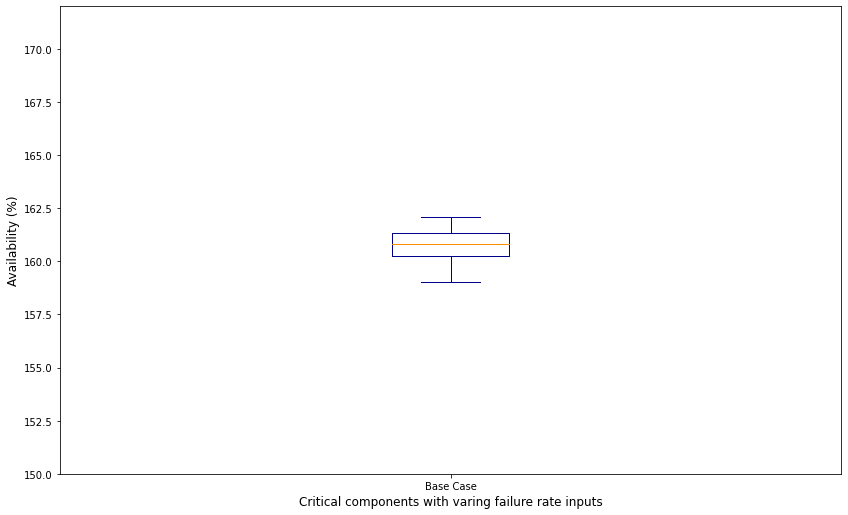

In [21]:
baseadf = pd.DataFrame(
                         {
                             "Base Case": basesa,
                         }
                     )

fig, ax = plt.subplots(figsize=(14, 8.6))
basecdf.plot(kind='box',ax=ax, color = color, ylim=(150,172))

plt.ylabel('Availability (%)', fontsize=12)
plt.xlabel('Critical components with varing failure rate inputs', fontsize=12)
#plt.xticks(index, label, fontsize=12, rotation=10)
#plt.title('Project availability with variable critical component reliability')
#ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#availabilitydf.describe()

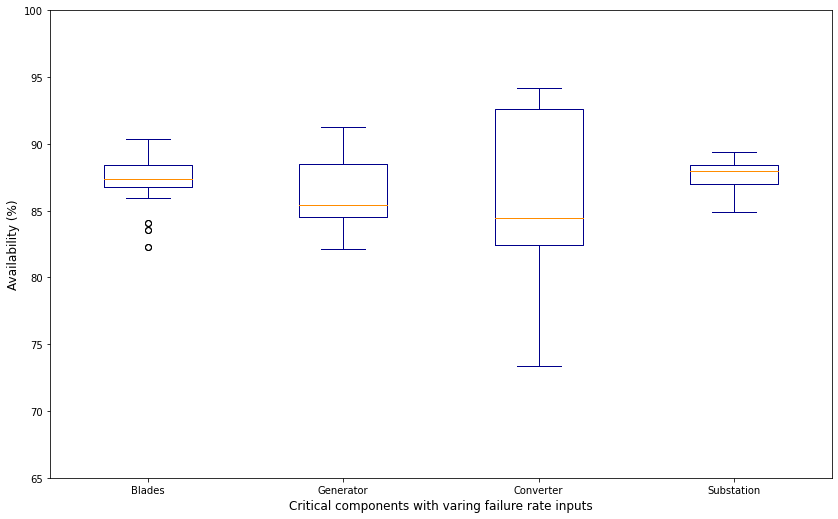

In [17]:
color = {
        "boxes": "DarkBlue",
        "whiskers": "DarkBlue",
        "medians": "DarkOrange",
        "caps": "DarkBlue",
    }

fig, ax = plt.subplots(figsize=(14, 8.6))
availabilitydf.plot(kind='box',ax=ax, color=color,ylim=(65,100))

plt.ylabel('Availability (%)', fontsize=12)
plt.xlabel('Critical components with varing failure rate inputs', fontsize=12)
#plt.xticks(index, label, fontsize=12, rotation=10)
#plt.title('Project availability with variable critical component reliability')
#ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#availabilitydf.describe()

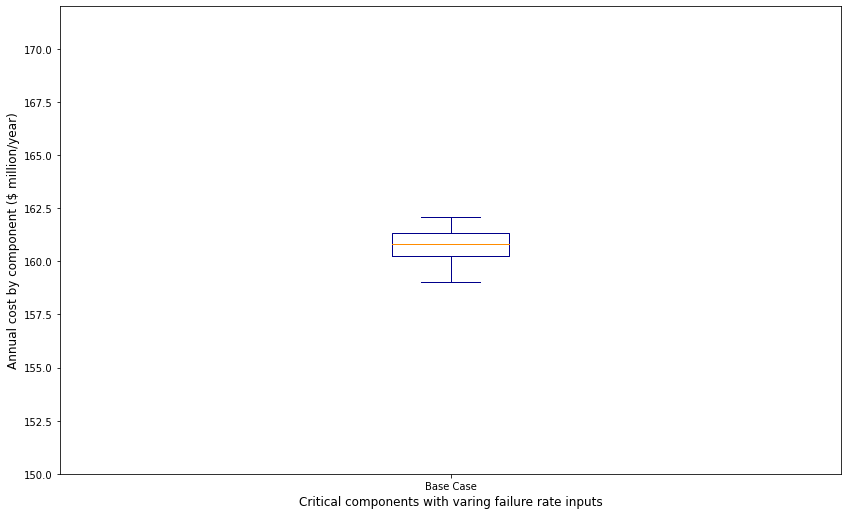

array([160.06903715, 161.17524115, 160.61046273, 161.86008982,
       162.10623958, 160.4851162 , 159.58443311, 159.8641323 ,
       160.84430454, 160.31242111, 161.28717301, 161.27719606,
       161.42747858, 161.01835454, 160.64288849, 161.93030511,
       159.01536854, 160.79254025, 161.57710568, 159.29487611,
       160.06903715, 161.17524115, 160.61046273, 161.86008982,
       162.10623958, 160.4851162 , 159.58443311, 159.8641323 ,
       160.84430454, 160.31242111, 161.28717301, 161.27719606,
       161.42747858, 161.01835454, 160.64288849, 161.93030511,
       159.01536854, 160.79254025, 161.57710568, 159.29487611])

In [20]:
basecdf = pd.DataFrame(
                         {
                             "Base Case": basesc,
                         }
                     )

fig, ax = plt.subplots(figsize=(14, 8.6))
basecdf.plot(kind='box',ax=ax, color = color, ylim=(150,172))

plt.ylabel('Annual cost by component ($ million/year)', fontsize=12)
plt.xlabel('Critical components with varing failure rate inputs', fontsize=12)
#plt.xticks(index, label, fontsize=12, rotation=10)
#plt.title('Annual direct O&M cost with variable critical component reliability')
#ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#costdf[["Blades","Generator","Converter","Substation"]].describe()

basesc

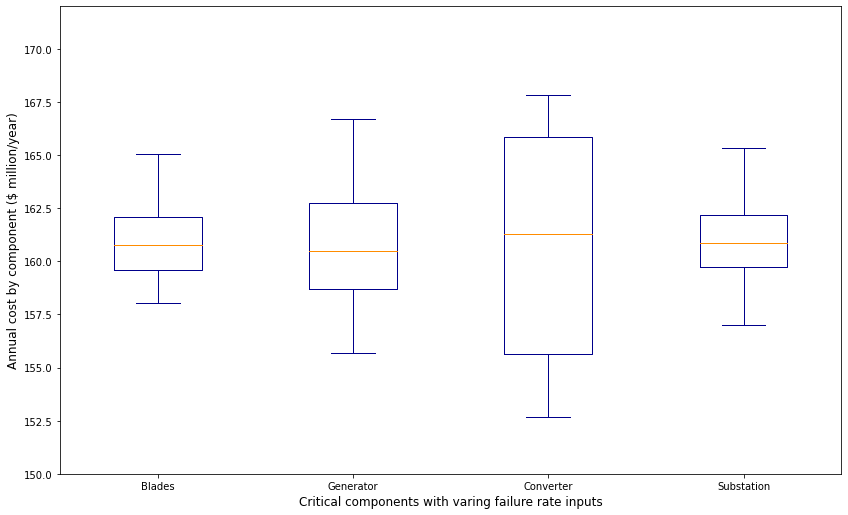

In [18]:
fig, ax = plt.subplots(figsize=(14, 8.6))
costdf.plot(kind='box',ax=ax, color = color, ylim=(150,172))

plt.ylabel('Annual cost by component ($ million/year)', fontsize=12)
plt.xlabel('Critical components with varing failure rate inputs', fontsize=12)
#plt.xticks(index, label, fontsize=12, rotation=10)
#plt.title('Annual direct O&M cost with variable critical component reliability')
#ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#costdf[["Blades","Generator","Converter","Substation"]].describe()

availability = pd.Series(results_df.loc["availability - time based"])
"""bases = results_df.loc["availability - time based",results_df.columns.str.startswith(f'{base}')].to_numpy()
bladess = results_df.loc["availability - time based",results_df.columns.str.startswith(f'{blades}')].to_numpy()
generatorss = results_df.loc["availability - time based",results_df.columns.str.startswith(f'{generator}')].to_numpy()
converterss = results_df.loc["availability - time based",results_df.columns.str.startswith(f'{converter}')].to_numpy()
substationss = results_df.loc["availability - time based",results_df.columns.str.startswith(f'{substation}')].to_numpy()

"""
#availability#
#results_df.loc["availability - time based"]#.loc["blades min u3config"]

label = columns 
"""
['Base Case',
 'High Blade Failure',
 'High Generator Failure',
 'High Converter Failure',
 'High Fixed Suport Structure Failure',
 #'High Floating Foundation Mooring Failure',
 'High Substation Failure',
 'High Cable Failure'] 
"""

"""['Minimum Failure Rates w/Uncertanty',
 'Minimum Failure Rates',
 'Mean Failure Rates',
 'Maximum Failure Rates',
 'Maximum Failure Rates w/Uncertanty'] """#columns #list(results_df.columns.values.tolist())
index = np.arange(len(label))
availability = results_df.loc["availability - time based"].to_numpy()*100 #0:len(configs)
cost = results_df.loc["annual direct O&M cost"].to_numpy()

#index = np.arange(len(labels))  # the label locations
#width = 0.35  # the width of the bars
label

In [ ]:
#results_df #no rutiene maintenece no weather 
#fm time/10 #ctv X3 SLV X3 HLV x3 DSV x1 cabbeling x1 
#Level 3 and 4 opperation reduction = 0

no routine maintenance
Repair window 5/1 - 7/30 
3x all vessels
Weather 
fm time/10 
Wind wave *5
Level 3 and 4 operation reduction = 1
2003 - 2009


# total O&M cost bar
compnentcostslogg = results_df.loc["annual repair cost"].to_numpy()
vesselecosts = results_df.loc["annual vessel cost from logg"].to_numpy()
technitioncost = results_df.loc["annual technician cost"].to_numpy()
delayEcost = results_df.loc["weather delay equipment cost"].to_numpy()
repairEcost = results_df.loc["repair equipment cost"].to_numpy()
norequestEcost = results_df.loc["no requests equipment cost"].to_numpy()
offshiftEcost = results_df.loc["not in shift equipment cost"].to_numpy()
mobilizationEcost = results_df.loc["mobilization equipment cost"].to_numpy()
ctvcost = results_df.loc["ctv cost"].to_numpy()
fsvcost = results_df.loc["fsv cost"].to_numpy()
hlvcost = results_df.loc["hlv cost"].to_numpy()
dsvcost = results_df.loc["dsv cost"].to_numpy()
cabcost = results_df.loc["cab cost"].to_numpy()
width = .2
"""
    "mobilization equipment cost": [],
    "weather delay equipment cost": [],
    "repair equipment cost": [],
    "no requests equipment cost": [],
    "not in shift equipment cost": [],"""

fig, ax = plt.subplots(figsize=(14, 8.6))
#ax.bar(index-width-.01, vesselecosts, width, label = "annual vessel cost from logg")
ax.bar(index-width/2-.01, delayEcost, width, label = "weather delay equipment cost")
ax.bar(index-width/2-.01, repairEcost, width, bottom = delayEcost, label = "repair equipment cost")
ax.bar(index-width/2-.01, norequestEcost, width, bottom = delayEcost+repairEcost, label = "no requests equipment cost")
ax.bar(index-width/2-.01, offshiftEcost, width, bottom = delayEcost+repairEcost+norequestEcost, label = "not in shift equipment cost")
ax.bar(index-width/2-.01, mobilizationEcost, width, bottom = delayEcost+repairEcost+norequestEcost+offshiftEcost, label = "mobilization equipment cost")
ax.bar(index+width/2+.01, ctvcost, width, label = "CTV")
ax.bar(index+width/2+.01, fsvcost, width, bottom = ctvcost, label = "FSV")
ax.bar(index+width/2+.01, hlvcost, width, bottom = ctvcost+fsvcost, label = "HLV")
ax.bar(index+width/2+.01, dsvcost, width, bottom = ctvcost+fsvcost+hlvcost, label = "DSV")
ax.bar(index+width/2+.01, cabcost, width, bottom = ctvcost+fsvcost+hlvcost+dsvcost, label = "Cabling")
#plt.xlabel('label', fontsize=12)
plt.ylabel('annual direct O&M cost (millions)', fontsize=12)
plt.xticks(index, label, fontsize=12, rotation=10)
plt.title('Vesel cost comparison per config')
ax.legend()
plt.show()
#https://medium.com/python-pandemonium/data-visualization-in-python-bar-graph-in-matplotlib-f1738602e9c4
#S1

componentcost
#componentcost.loc[:,"materials_cost"]/ mil / years #.to_numpy()/ mil / years


# total Vesel cost bar
compnentcostslogg = results_df.loc["annual repair cost"].to_numpy()
vesselecosts = results_df.loc["annual vessel cost from logg"].to_numpy()
technitioncost = results_df.loc["annual technician cost"].to_numpy()
fixedCosts = results_df.loc["fixed costs"].to_numpy()#-technitioncost
width = .35

fig, ax = plt.subplots(figsize=(14, 8.6))
ax.bar(index-width/2-.01, cost, width, label = "annual O&M cost")
ax.bar(index+width/2+.01, compnentcostslogg, width, label = "annual repair cost")
ax.bar(index+width/2+.01, vesselecosts, width, bottom = compnentcostslogg, label = "annual vessel cost from logg")
ax.bar(index+width/2+.01, technitioncost, width, bottom = compnentcostslogg+vesselecosts, label = "annual technician cost")
#ax.bar(index+width/2+.01, fixedCosts, width, bottom = compnentcostslogg+vesselecosts+technitioncost, label = "annual fixed costs")
#plt.xlabel('label', fontsize=12)
plt.ylabel('annual direct O&M cost (millions)', fontsize=12)
plt.xticks(index, label, fontsize=12, rotation=10)
plt.title('O&M cost comparison per config')
ax.legend()
plt.show()
vesselecosts
#S1

# availability bar
plt.subplots(figsize=(14, 8.6))
plt.bar(index, availability)
plt.xlabel('config', fontsize=10)
plt.ylabel('time based availability (%)', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=30)
plt.title('availability per config')
plt.show()
#https://medium.com/python-pandemonium/data-visualization-in-python-bar-graph-in-matplotlib-f1738602e9c4

compcost = results_df.at['compoment cost','FRmaxUncertantyconfig']#.to_numpy()
x=1
print(compcost[1][13])
results_df.at['compoment cost','FRmaxUncertantyconfig']
#c = componentcost.to_numpy()
#c[0][0]
res = np.where(results_df.at['compoment cost','FRmaxUncertantyconfig'][0] == f'{component}')
compindex = res[0][0]
componentcost

"""label = columns #list(results_df.columns.values.tolist())
index = np.arange(len(label))"""
compnentcostslogg = results_df.loc["annual repair cost"].to_numpy()
vesselecosts = results_df.loc["annual vessel cost from logg"].to_numpy()
technitioncost = results_df.loc["annual technician cost"].to_numpy()

In [ ]:
#results_df.at['compoment cost','substation0config']#.to_numpy()

components = ['cable', 
              'drive_train', 
              'electrical_system', 
              'electronic_control',
              'generator', 
              'hydraulic_system', 
              'rotor_blades', 
              'rotor_hub', 
              'supporting_structure',
              'transformer',
              'yaw_system',
             ]
componentslabel = ['Cable',
                   'Drivetrain', 
              'Converter', 
              'Control',
              'Generator', 
              'Hydraulic system', 
              'Blades', 
              'Hub', 
              'Supporting structure',
              'Substation',
              'Yaw system',
             ]



width = .35
oldcostcomp = [0,0,0,0,0,0,0] #None #

compind = 0
print(label[4])
fig, ax = plt.subplots(figsize=(14, 8.6))
"""ax.bar(index+width/2, compnentcostslogg, width, label = "annual repair cost")
ax.bar(index+width/2, vesselecosts, width, bottom = compnentcostslogg, label = "annual vessel cost from logg")
ax.bar(index+width/2, technitioncost, width, bottom = compnentcostslogg+vesselecosts, label = "annual technician cost")"""
for component in components:
    res = np.where(results_df.at['compoment cost',f'{columns[3]}'][0] == f'{component}')
    compindex = res[0][0]
    #print(results_df.at['compoment cost','FRminconfig'][0][compindex])
    costcomp = [float(results_df.at['compoment cost',f'{columns[0]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[1]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[2]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[3]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[4]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[5]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[6]}'][1][compindex])]
    #print(f'{component}')
    #print(oldcostcomp)
    ax.bar(index, costcomp, bottom = oldcostcomp, label = f'{componentslabel[compind]}')
    #print(costcomp)
    oldcostcomp = np.add(oldcostcomp,costcomp)
    compind += 1


plt.ylabel('annual cost by component (millions)', fontsize=12)
plt.xticks(index, label, fontsize=12, rotation=10)
plt.title('cost by component per config')
ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#S1

no routine maintenance
Repair window 5/1 - 7/30 
3x all vessels
Weather 
fm time/10 
Wind wave *5
Level 3 and 4 operation reduction = 1
2003 - 2009


components = ['drive_train', 
              'electrical_system', 
              'electronic_control',
              'generator', 
              'hydraulic_system', 
              'rotor_blades', 
              'rotor_hub', 
              'supporting_structure',
              'transformer',
              'yaw_system',
             ]
componentslabel = ['Drivetrain', 
              'Converter', 
              'Control',
              'Generator', 
              'Hydraulic system', 
              'Blades', 
              'Hub', 
              'Supporting structure',
              'Substation',
              'Yaw system',
             ]


width = .35
oldcostcomp = [0,0,0,0,0,0,0] #None #
compind = 0
print(label[4])
fig, ax = plt.subplots(figsize=(14, 8.6))
"""ax.bar(index+width/2, compnentcostslogg, width, label = "annual repair cost")
ax.bar(index+width/2, vesselecosts, width, bottom = compnentcostslogg, label = "annual vessel cost from logg")
ax.bar(index+width/2, technitioncost, width, bottom = compnentcostslogg+vesselecosts, label = "annual technician cost")"""
for component in components:
    res = np.where(results_df.at['compoment cost',f'{columns[3]}'][0] == f'{component}')
    compindex = res[0][0]
    #print(results_df.at['compoment cost','FRminconfig'][0][compindex])
    costcomp = [float(results_df.at['compoment cost',f'{columns[0]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[1]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[2]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[3]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[4]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[5]}'][1][compindex]),
            float(results_df.at['compoment cost',f'{columns[6]}'][1][compindex])]
    #print(f'{component}')
    #print(oldcostcomp)
    ax.bar(index, costcomp, bottom = oldcostcomp, label = f'{componentslabel[compind]}')
    #print(costcomp)
    oldcostcomp = np.add(oldcostcomp,costcomp)
    compind += 1

#plt.xlabel('label', fontsize=12)
plt.ylabel('annual cost by component (millions)', fontsize=12)
plt.xticks(index, label, fontsize=12, rotation=10)
plt.title('Cost by component per config without cabel')
ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#S1

timeToCompletion = results_df.loc["time to completion"].to_numpy()
processTime = results_df.loc["process time"].to_numpy()
totalDowntime = results_df.loc["total downtime"].to_numpy()
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8.6))
ax.bar(index - width, timeToCompletion, width, label = "time to completion")
ax.bar(index, totalDowntime , width, label = "total downtime")
ax.bar(index + width, processTime, width, label = "process time")

plt.xlabel('label', fontsize=10)
plt.ylabel('Hours per year per failure', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=30)
plt.title('Repair time metrics')
ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()

no routine maintenance
Repair window 5/1 - 7/30 
3x all vessels
Weather 
fm time/10 
Wind wave *5
Level 3 and 4 operation reduction = 1
2003 - 2009



oldcostcomp = None
#handle = []
fig, ax = plt.subplots(figsize=(14, 8.6))
for column in columns:
    name = f'{column}'
    compcost = results_df.at['compoment cost',f'{column}']
    label = compcost[0]
    costcomp = compcost[1]
    index = np.arange(len(label))
    # component cost satacked bar
    ax.scatter(index, costcomp,label = f'{column}')#,bottom = oldcostcomp)
    #handle.append(name)
    #oldcostcomp =
plt.xlabel('config', fontsize=10)
plt.ylabel('annual cost by component (millions)', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=30)
plt.title('cost by component per config')
ax.legend()#handles = handle, loc="lower left", fontsize=14)
plt.show()
#https://medium.com/python-pandemonium/data-visualization-in-python-bar-graph-in-matplotlib-f1738602e9c4

Cost per component per config, no rutiene maintenece, with weather, fm time/10, ctv X3 SLV X3 HLV x3 DSV x1 cabbeling x1, Level 3 and 4 opperation reduction = 0

fig, ax = plt.subplots(figsize=(14, 8.6))
handle = []
yearsrange = range(2003,(2003+years+1))
#print(yearsrange)
for column in columns:
    name = f'{column}'
    months = range(0,1+len(results_df.at['availability - monthly',f'{column}']),1)
    data = np.concatenate(([1], results_df.at['availability - monthly',f'{column}']), axis=None)*100
    name, = plt.plot(months,data,label = f'{column}')
    handle.append(name)
#plt.xlabel('symulation time (Months)')

xticks_major = [x * 12 for x in range((years+1))]
#print(xticks_major)
xticks_minor = list(range(0, 12 * (years), 1))
#print(len(xticks_minor))
xlabels_major = [f"{yearr:> 5}" for yearr in yearsrange]
#print(xlabels_major)
#xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * int((len(xticks_minor)-3)/3)
#print(len(xlabels_minor))
ax.set_xlabel("Simulation Time", fontsize=16)

#ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
#for t in ax.get_xticklabels():
#    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
#ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)
plt.ylabel('Availability (%)')
plt.title('Availability Over Time')
plt.legend(handles = handle, loc="lower left", fontsize=14)
plt.show()
#S1

no routine maintenance
Repair window 5/1 - 7/30 
3x all vessels
Weather 
fm time/10 
Wind wave *5
Level 3 and 4 operation reduction = 1
2003 - 2009




plt.subplots(figsize=(14, 8.6))
handle = []
for column in columns:
    name = f'{column}'
    months = range(0,1+len(results_df.at['availability - monthly',f'{column}']),1)
    data = np.concatenate(([1], results_df.at['availability - monthly',f'{column}']), axis=None)*100
    name, = plt.plot(months,data,label = f'{column}')
    handle.append(name)
plt.xlabel('symulation time (Months)')
plt.ylabel('Availability (%)')
plt.title('Availability Over Time')
plt.legend(handles = handle, loc="lower left", fontsize=14)
plt.show()

"""label = columns #list(results_df.columns.values.tolist())
index = np.arange(len(label))"""
availability = results_df.loc["availability - time based"].to_numpy()*100 #0:len(configs)
cost = results_df.loc["annual direct O&M cost"].to_numpy()*mil#/1200


# Availability cost plot
fig, ax = plt.subplots(figsize=(14, 8.6))
nunum=0
for column in columns:
    ax.scatter(cost[int(nunum)],availability[int(nunum)],label = f'{label[nunum]}')
    nunum += 1

x_ticks = range(int(np.amin(cost)),int(np.amax(cost)),2000000)#, 
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:,.0f}" for x in x_ticks])

y_ticks = range(0, 101, 10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.0f}%" for y in y_ticks])

ax.grid(alpha=0.5)
ax.set_axisbelow(True)

#ax.set_xlim(-1500, 180000)
#ax.set_ylim(0, 100)

ax.set_xlabel("Annualized Cost (USD/year)", fontsize=14)#/MW
ax.set_ylabel("Windfarm Availability", fontsize=14)
ax.legend()
plt.show()

#s1
T = sim.metrics.process_times()
T

T = T/ years #/ 80 #/ 100 
T

    """Crew data class.

    Parameters
    ----------
    name: str
        Name of the piece of equipment.
    equipment_rate: float
        Day rate for the equipment/vessel, in USD.
    day_rate: float
        Day rate for salaried workers, in USD.
    n_day_rate: int
        Number of salaried workers.
    hourly_rate: float
        Hourly labor rate for subcontractors, in USD.
    n_hourly_rate: int
        Number of hourly/subcontractor workers.
    start_month : int
        The day to start operations for the rig and crew.
    start_day : int
        The month to start operations for the rig and crew.
    start_year : int
        The year to start operations for the rig and crew.
    end_month : int
        The month to end operations for the rig and crew.
    end_day : int
        The day to end operations for the rig and crew.
    end_year : int
        The year to end operations for the rig and crew.
        ... note:: if the rig comes annually, then the enter the year for the last year
        that the rig and crew will be available.
    capability : str
        The type of capabilities the equipment contains. Must be one of:
         - RMT: remote (no actual equipment BUT no special implementation)
         - DRN: drone
         - CTV: crew transfer vessel/vehicle
         - SCN: small crane (i.e., field support vessel)
         - LCN: large crane (i.e., heavy lift vessel)
         - CAB: cabling vessel/vehicle
         - DSV: diving support vessel
    mobilization_cost : float
        Cost to mobilize the rig and crew.
    mobilization_days : int
        Number of days it takes to mobilize the equipment.
    speed : float
        Maximum transit speed, km/hr.
    max_windspeed_transport : float
        Maximum windspeed for safe transport, m/s.
    max_windspeed_repair : float
        Maximum windspeed for safe operations, m/s.
    max_waveheight_transport : float
        Maximum waveheight for safe transport, m, default 1000 (land-based).
    max_waveheight_repair : float
        Maximum waveheight for safe operations, m, default 1000 (land-based).
    workday_start : int
        The starting hour of a workshift, in 24 hour time.
    workday_end : int
        The ending hour of a workshift, in 24 hour time.
    onsite : bool
        Indicator for if the rig and crew are based onsite.
        ... note:: if the rig and crew are onsite be sure that the start and end dates
        represent the first and last day/month of the year, respectively, and the start
        and end years represent the fist and last year in the weather file.
    method : str
        Determines if the ship will do all maximum severity repairs first or do all
        the repairs at one turbine before going to the next, by default severity.
        Should by one of "severity" or "turbine".
    max_severity : int
        Maximum severity failure that a crew can service, default None.
    """


"""xticks_major = [x * 12 for x in range(21)]
xticks_minor = list(range(0, 12 * 20, 3))
xlabels_major = [f"{year:>6}" for year in years]
xlabels_minor = ["Apr", "", "Oct"] + ["Apr", "", "Oct"] * 19
ax.set_xlabel("Simulation Time", fontsize=16)

#ax.set_xlim(0, 300)
ax.set_xticks(xticks_major)
for t in ax.get_xticklabels():
    t.set_y(-0.05)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xlabels_major, ha="left", fontsize=12)
ax.set_xticklabels(xlabels_minor, minor=True, rotation=90)"""
#availabilitym #.iloc[:,0].to_numpy()